## Authenticate with Hugging Face Hub

To access models or datasets hosted privately on Hugging Face, we first log in using the `huggingface_hub` package. This step is necessary if you're accessing gated models or datasets with a token.

In [3]:
from huggingface_hub import login

login()

## Load Dataset and Prepare Documents

We use the `datasets` library to load the `"agents-course/unit3-invitees"` dataset, which contains structured information about invited guests. Then we convert each entry into a `Document` object from LangChain.

Each document includes:
- Name
- Relation
- Description
- Email

These will be used later for semantic retrieval.

In [6]:
import datasets
from langchain.docstore.document import Document

# Load the dataset
guest_dataset = datasets.load_dataset("agents-course/unit3-invitees", split="train")

# Convert dataset entries into Document objects
docs = [
    Document(
        page_content="\n".join([
            f"Name: {guest['name']}",
            f"Relation: {guest['relation']}",
            f"Description: {guest['description']}",
            f"Email: {guest['email']}"
        ]),
        metadata={"name": guest["name"]}
    )
    for guest in guest_dataset
]

README.md:   0%|          | 0.00/371 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.32k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3 [00:00<?, ? examples/s]

## Generate Embeddings with SentenceTransformers

We load the `all-MiniLM-L6-v2` model using the `sentence-transformers` library to compute dense embeddings for each document.

This allows us to:
- Turn each guest description into a vector
- Compare queries to those vectors using cosine similarity

We also define a retrieval function `extract_text()` that:
1. Encodes the user query
2. Computes cosine similarities with all documents
3. Returns the top 3 most semantically similar entries

In [8]:
from sentence_transformers import SentenceTransformer, util
import torch

# Load model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Convert docs to embeddings
corpus = [doc.page_content for doc in docs]
corpus_embeddings = model.encode(corpus, convert_to_tensor=True)

# Define retrieval function
def extract_text(query: str) -> str:
    """Retrieves semantically relevant guest info using sentence-transformers."""
    query_embedding = model.encode(query, convert_to_tensor=True)
    scores = util.cos_sim(query_embedding, corpus_embeddings)[0]

    # Get top 3 results
    top_results = torch.topk(scores, k=3)

    if top_results.indices.numel() == 0:
        return "No matching guest information found."

    return "\n\n".join([corpus[idx] for idx in top_results.indices])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Wrap the Retrieval Function as a LangChain Tool

To integrate our semantic search function with LangChain's agent ecosystem, we wrap `extract_text()` in a `Tool`.

This allows language models (LLMs) in LangChain to invoke this function based on the context of user queries. We give the tool a name and description, which help the agent know when to use it.


In [9]:
# LangChain Tool wrapping
from langchain.tools import Tool

guest_info_tool = Tool(
    name="guest_info_retriever",
    func=extract_text,
    description="Retrieves detailed information about gala guests based on their name or relation using semantic similarity."
)

## 🔎 Test Retrieval Function

We do a quick test of our `extract_text()` function to ensure it returns meaningful information based on a query.

This example asks for information related to someone with the title "CEO", and the model returns the most semantically relevant guests based on cosine similarity of the embeddings.

In [10]:
print(extract_text("Who is related as the CEO?"))

Name: Dr. Nikola Tesla
Relation: old friend from university days
Description: Dr. Nikola Tesla is an old friend from your university days. He's recently patented a new wireless energy transmission system and would be delighted to discuss it with you. Just remember he's passionate about pigeons, so that might make for good small talk.
Email: nikola.tesla@gmail.com

Name: Ada Lovelace
Relation: best friend
Description: Lady Ada Lovelace is my best friend. She is an esteemed mathematician and friend. She is renowned for her pioneering work in mathematics and computing, often celebrated as the first computer programmer due to her work on Charles Babbage's Analytical Engine.
Email: ada.lovelace@example.com

Name: Marie Curie
Relation: no relation
Description: Marie Curie was a groundbreaking physicist and chemist, famous for her research on radioactivity.
Email: marie.curie@example.com


## Build the Agent with LangGraph

Now we define the logic of our RAG agent using LangGraph.

Steps:
1. Define the agent's **state structure** using `TypedDict`.
2. Define the **assistant node**, which is responsible for:
   - Receiving messages
   - Passing them to the chat model (which can use tools)
   - Returning updated messages
3. Configure the graph with:
   - Nodes: `assistant`, `tools`
   - Edges: connections between nodes and conditional tool routing

This enables automatic back-and-forth between the LLM and tools in a structured, event-driven graph.

In [12]:
import os

from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain.tools import Tool

# Your previous semantic tool
from sentence_transformers import SentenceTransformer, util
import torch

# Load model and encode docs
model = SentenceTransformer("all-MiniLM-L6-v2")
corpus = [doc.page_content for doc in docs]
corpus_embeddings = model.encode(corpus, convert_to_tensor=True)

def extract_text(query: str) -> str:
    query_embedding = model.encode(query, convert_to_tensor=True)
    scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = torch.topk(scores, k=3)
    if top_results.indices.numel() == 0:
        return "No matching guest information found."
    return "\n\n".join([corpus[idx] for idx in top_results.indices])

guest_info_tool = Tool(
    name="guest_info_retriever",
    func=extract_text,
    description="Retrieves detailed information about gala guests based on their name or relation using semantic similarity."
)

# Define LLM
HUGGINGFACEHUB_API_TOKEN = os.getenv("HUGGINGFACEHUB_API_TOKEN")  # or set manually
llm = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen2.5-Coder-32B-Instruct",
    huggingfacehub_api_token=HUGGINGFACEHUB_API_TOKEN,
)
chat = ChatHuggingFace(llm=llm, verbose=True)

# Bind tools to chat
tools = [guest_info_tool]
chat_with_tools = chat.bind_tools(tools)

# Agent state
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Assistant logic
def assistant(state: AgentState) -> AgentState:
    return {
        "messages": [chat_with_tools.invoke(state["messages"])],
    }

# Build graph
builder = StateGraph(AgentState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")
alfred = builder.compile()

# Example run
messages = [HumanMessage(content="Tell me about our guest named 'Lady Ada Lovelace'.")]
response = alfred.invoke({"messages": messages})

print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

🎩 Alfred's Response:
It looks like there was a mix-up in the response. Let me provide you with the accurate information about Lady Ada Lovelace:

**Name:** Ada Lovelace  
**Full Name:** Augusta Ada King, Countess of Lovelace  
**Birth:** December 10, 1815, London, England  
**Death:** November 27, 1852, Marylebone, London, England  
**Profession:** Mathematician and writer  

**Description:**  
Lady Ada Lovelace is widely regarded as the first computer programmer. She is famous for her work on Charles Babbage's Analytical Engine, a mechanical general-purpose computer that was never fully built in her lifetime. Lovelace saw the potential of the machine beyond mere calculations and wrote what is recognized as the first algorithm intended to be processed by a machine. Her notes include what is now considered the first computer program. Lovelace's contributions were ahead of her time, and her insights into the capabilities of computing machines have been influential long after her passing.

## Run the Agent!

We now send a query to our agent and observe the output.

The input simulates a user at a formal event asking Alfred (the assistant) who a specific guest is. The graph routes the query through the appropriate nodes, optionally uses the tool, and returns a detailed, conversational response.

In [13]:
# Example run
messages = [HumanMessage(content="Alfred, who is that gentleman talking to the ambassador?")]
response = alfred.invoke({"messages": messages})

print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

🎩 Alfred's Response:
Based on the provided information, it appears that Alfred is likely Dr. Nikola Tesla, considering he is described as an old friend from university days who is passionate about pigeons and has recently patented a new wireless energy transmission system. So, the gentleman talking to the ambassador is Dr. Nikola Tesla.


## 🔄 Agent Workflow Visualization

The diagram below illustrates the control flow of our LangGraph-powered Retrieval-Augmented Generation (RAG) agent.

This setup enables your assistant (e.g., "Alfred") to respond with accurate information based on both reasoning and retrieval.

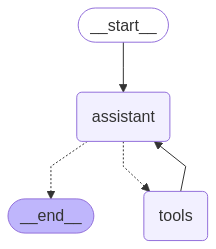

In [22]:
from IPython.display import Image, display
compiled_graph = builder.compile()
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

## Conclusion

In this notebook, we built a fully local, GPU-accelerated RAG assistant powered by:

- **`sentence-transformers`** for dense semantic search
- **LangChain Tool abstraction** for connecting external logic

This agent can:
- Understand complex natural language questions
- Decide whether to use tools
- Retrieve relevant information
- Provide rich, natural responses

### Next Steps

- Integrate more tools (e.g., calendar, email, documents)
- Swap the LLM model (`llama3`, `mistral`, `qwen`) for different behaviors
- Deploy with FastAPI, Streamlit, or Gradio
- Persist your vector index using `faiss` for large-scale RAG

Alfred is now ready to serve.